# Space charge problem applied to HVDC power transmission

We want to find a couple of solution $(\rho,\varphi)$ on a domain $\Omega$ to the system :
\begin{align*}
\Delta \varphi = -\rho \quad &\text{in } \Omega\\
\nabla \cdot (\rho \nabla \varphi) = 0 \quad &\text{in } \Omega \\
\varphi = 1, \quad  &\text{on } \Gamma_c, \\
\varphi = 0, \quad  &\text{on } \Gamma_d, \\
\nabla \varphi \cdot n = A,\quad &\text{on } \Gamma_c.
\end{align*}
where $\varphi$ is the potential of the electric field and $\rho$ is the positive charge density. $A$ is a constant and $\Gamma_c$ is the boundary of the conductor (interior boundary) and $\Gamma_d$ is the air or the ground (exterior boundary).

![alttext](figure.png)

In [76]:
from netgen.geom2d import CSG2d, Circle, Rectangle
from ngsolve import *
import ngsolve
import numpy as np
import scipy
from ngsolve.webgui import Draw
from ngsolve import Mesh, VOL

## Generate mesh on the domain

In [77]:

geo = CSG2d()
cercle_ext = Circle(center = (0,0), radius = 1.0, bc = "label_ext")
circle_int = Circle(center = (0,0), radius = 0.5, bc = "label_int")
domain = cercle_ext-circle_int
geo.Add(domain)
m = geo.GenerateMesh(maxh = 0.1)
mesh = Mesh(m)
Draw(mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [78]:
    
def discret_to_grid(tab : np.ndarray, flag : bool) -> GridFunction:
    """
    Transform an array (tab) to a GridFunction

    Parameters
    ----------
    tab : np.ndarray
        discret function on H1

    Out
    -------
    GridFunction : tab transformed in GridFunction 

    Error
    -------
    IndexError : if the size of the array doesn't correspond to the mesh
    """
    if flag == True:
        fes = H1(mesh, order = 1)
    else:
        fes = L2(mesh, order = 1)
    gf = GridFunction(fes)
    if not gf.vec.size == len(tab):
        raise IndexError
    gf.vec[:] = tab
    return gf 
    

## Solving Process

Let $\rho$ be fixed and one solve the system for $\varphi$.
We divide the system into two systems. The first one is :
\begin{align*}
\Delta \varphi = -\rho \quad &\text{in } \Omega\\
\varphi = 0, \quad  &\text{on } \Gamma_d, \\
\nabla \varphi \cdot n = A,\quad &\text{on } \Gamma_c.
\end{align*}

In [79]:
A = 1.5      

def solve_phi1(ρ : GridFunction) -> GridFunction:
    """
    Solve the equation Δφ = -ρ in φ where ρ is fixed with the mixte condition on the boundary ie : ∇φ n=-A on the interior boundary ,φ=0 on the exterior boundary

    Parameter:
    ------------
    ρ : GridFunction
        ρ discret on the mesh
    
    Out:
    --------
    GridFunction : φ discret on the mesh
    """
    fes = H1(mesh, order = 1, dirichlet = "label_ext")
    uD = CF(0)
    uN = mesh.BoundaryCF({'label_int':A}, default = 0)
    sol = GridFunction(fes)
    u,v = fes.TnT()
    a = BilinearForm(grad(u)*grad(v)*dx).Assemble()
    f = LinearForm(ρ*v*dx + uN*v*ds).Assemble()
    sol.Set(uD,BND)
    c= Preconditioner(a, "local")
    c.Update()
    solvers.BVP(bf = a, lf = f, gf = sol, pre = c, print = False)
    return sol




Then, we solve :
\begin{align*}
\nabla \cdot (\rho \nabla \varphi) = 0 \quad &\text{in } \Omega \\
\varphi = 1, \quad  &\text{on } \Gamma_c, \\
\varphi = 0, \quad  &\text{on } \Gamma_d
\end{align*}

In [80]:
def solve_phi2(ρ: GridFunction) ->  GridFunction:
    """
    Solve the equation -∇ ∙ ((ρ+1) ∇φ) =ρ  with the Dirichlet conditions on the boundaries, ie : φ=0 on the exterior circle and φ = 1 on the interior circle

    Paramètres :
    -----------
    ρ : GridFunction   
        ρ discret on the mesh
        
    Sortie:
    --------
    sol : Gridfunction
        function solution on the mesh
    """
   
    fes = H1(mesh, order = 1, dirichlet = "label_ext|label_int")
    g = mesh.BoundaryCF({"label_ext":0 , "label_int":1}, default = 0)
    u,v = fes.TnT()
    a = BilinearForm((ρ+1)*grad(u)*grad(v)*dx).Assemble()
    f = LinearForm(ρ*v*dx).Assemble() 
    sol = GridFunction(fes)
    sol.Set(g,BND)
    c= Preconditioner(a, "local")
    c.Update()
    solvers.BVP(bf = a, lf = f, gf = sol, pre = c, print = False)
    return sol




## Minimisation algorithm

For solving the whole system, we will minimize the function $J(\rho) = 1/2 |\nabla \varphi_1-\nabla \varphi_2|_2^2$ where $\varphi_1$ (resp. $\varphi_2$) is the solution for the first (resp. second) system.
So, we need to calculate the gradient of the function $J$. 
So we need to solve the following equation, for $u = \nabla J(\rho)$ :
\begin{align*}
    \int_\Omega u z + \nabla u \nabla z  dx = \int_\Omega \nabla(\varphi_1-\varphi_2) \nabla(\partial_\rho \varphi_1 [z]- \partial_\rho \varphi_2[z])  dx.
\end{align*}
Here, we had a problem because in the right member of this equality, we can see that the test function $z$ is not explicit (it's hidden in the differential). For solving this problem, we solve an intermediate system for $\Psi$:
\begin{align*}
    \nabla \cdot \Bigl((\rho(x) +1) \nabla \Psi(x)\Bigr) = \Delta (\varphi_1(x)    -\varphi_2(x)), & \hspace*{1ex} \text{ pour } x \in \Omega, \\
    \Psi(x) = 0, & \hspace*{1ex} \text{ pour } x \in \partial \Omega.
\end{align*}

In [81]:
def solve_psi(ϕ1 : GridFunction, ϕ2 : GridFunction, ρ : GridFunction) -> GridFunction:
    """
    Solve the equation -∇ ∙ ((ρ+1) ∇ψ) = Δ(ϕ1-ϕ2) with Dirichlet boundary ie ψ = 0 
    Parameter:
    ----------
    ϕ1 : Gridfunction
        function solution obtained by solve_phi1
    ϕ2 : GridFunction
        function solution obtained by solve_phi2
    ρ : GridFunction
        ρ discret on the mesh
    
    Out:
    --------
    GridFunction : function solution on the mesh
    """
    fes = H1(mesh, order = 1, dirichlet = "label_ext|label_int")
    g = mesh.BoundaryCF({"label_ext":0, "label_int":0}, default = 0)
    u,v = fes.TnT()
    a = BilinearForm((ρ+1)*grad(u)*grad(v)*dx).Assemble()
    fes_H0 = H1(mesh, order = 1, dirichlet = "label_ext")
    soustract = GridFunction(fes_H0)
    soustract.Set(ϕ1-ϕ2)
    f = LinearForm(grad(soustract)*grad(v)*dx).Assemble() 
    sol = GridFunction(fes)
    sol.Set(g,BND)
    c= Preconditioner(a, "local")
    c.Update() 
    solvers.BVP(bf = a, lf = f, gf = sol, pre = c, print = False)
    return sol


def grad_J(ρ : np.ndarray) -> np.ndarray:
    """
    Calculate the gradient of the function to minimize in H1

    Parameter
    -----------
    ρ : np.ndarray
        ρ as an array
    
    Sortie
    -------
    np.ndarray : gradient of J 
    """
    ρ_grid = discret_to_grid(ρ, True)
    ϕ1 = solve_phi1(ρ_grid)
    ϕ2 = solve_phi2(ρ_grid)
    psi = solve_psi(ϕ1, ϕ2, ρ_grid)
    fes = H1(mesh, order=1)
    u,v = fes.TnT()
    sol = GridFunction(fes)
    a = BilinearForm(grad(u)*grad(v)*dx + u*v*dx).Assemble()
    f = LinearForm((ϕ1-ϕ2-psi + grad(ϕ2)*grad(psi))*v*dx)
    c = Preconditioner(a, "local")
    c.Update()
    solvers.BVP(bf = a, lf = f, gf = sol, pre = c, print = False)
    grad_J_array = np.array(sol.vec)
    return grad_J_array



## Minimization

We define the function $J$ and we minimize it.

In [82]:
def inner_H1_0(u : GridFunction,v : GridFunction) -> float:
        """
        Calculate the scalar product H¹₀

        Parameter:
        ----------
        u, v : Gridfunction

        Out
        -------
        float : scalar product H¹₀ of u and v
        """
        fes = H1(mesh, order = 1, dirichlet = "label_ext|label_int")
        u_H1_0,v_H1_0 = fes.TnT()
        a = BilinearForm(grad(u_H1_0)*grad(v_H1_0)*dx).Assemble()
        return InnerProduct(u.vec,a.mat*v.vec)

def norme_H1_0_carre(u : GridFunction) -> float:
    """
    Calculate the norm H¹₀ to the square

    Parameter
    ----------
    u : Grifunction

    Out
    --------
    float : norm H¹₀ to the square of u
    """
    return inner_H1_0(u,u)


def J(ρ : np.ndarray) -> float:
    """
    Calculate the function to minimize, J

    Parameter
    ---------
    ρ : np.ndarray
        ρ discret as an array
    """
    ρ_grid = discret_to_grid(ρ,True)
    ϕ1 = solve_phi1(ρ_grid)
    ϕ2 = solve_phi2(ρ_grid)
    fes = H1(mesh, order = 1, dirichlet = "label_ext")
    soustract = GridFunction(fes)
    soustract.Set(ϕ1-ϕ2)
    return 1/2 * norme_H1_0_carre(soustract)

def minimize(ρ : np.ndarray):
    """
    Minimize function
    
    """
    min = scipy.optimize.minimize(J, ρ,
                                method = "L-BFGS-B", jac = grad_J, tol = 1e-9, options = {'ftol' : 1e-9, 'gtol' : 1e-9})
    return min

H1 105 True 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


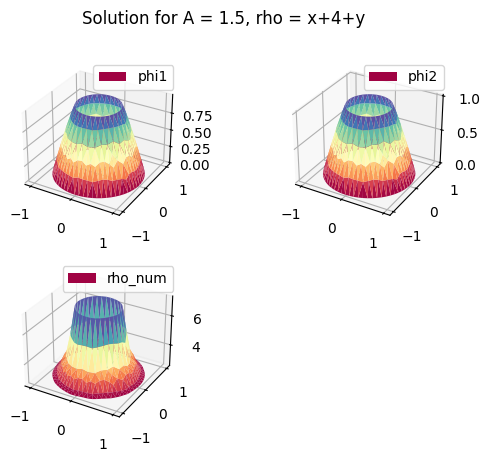

In [83]:
import matplotlib.pyplot as plt
from ngsolve import *
import ngsolve
import math
import matplotlib.tri as mtri


def rho(x,λ,r_0):
    if λ >=-1:
        return λ/((f(λ,r_0,1)-f(λ,r_0,r_0))*sqrt(λ*x**2+1))
    elif λ <= -1/r_0**2:
        return  -λ/((f(λ,r_0,1)-f(λ,r_0,r_0))*sqrt(-λ*x**2-1))

def f(λ,r_0,x):
    if λ >=-1:
        return sqrt(1+λ*x**2)- log(sqrt(1+λ*x**2)+1)+log(x)
    if λ <= -1/r_0**2:
        return sqrt(-λ*x**2-1)-atan(sqrt(-λ*x**2-1))

def A_lambda(λ):
    return math.sqrt(abs(λ+1/r_0**2))/ (f(λ,r_0,1)-f(λ,r_0,r_0))


def ϕ(λ,r_0,x):
    return (f(λ,r_0,1)-f(λ,r_0,x))/(f(λ,r_0,1)-f(λ,r_0,r_0))

r_0 = 0.5
λ = -10

fes = H1(mesh, order = 1)



ρ_grid = GridFunction(fes)
ρ_grid.Set(x+y +4) 
ρ_array = np.array(ρ_grid.vec)
ρ_init = ρ_array


res_H1 = minimize(ρ_array)
print("H1",res_H1.nit, res_H1.success, res_H1.status, res_H1.message)
ρ_sol_grid_H1 = discret_to_grid(res_H1.x, True)
phi1_H1 = solve_phi1(ρ_sol_grid_H1)
phi2_H1 = solve_phi2(ρ_sol_grid_H1)


triangles = []

for el in mesh.Elements(VOL): 
    v = el.vertices
    triangles.append([v[0].nr, v[1].nr, v[2].nr])


fig = plt.figure()
ax = fig.add_subplot(2,2,1,projection ='3d')

X = np.array([v.point[0] for v in mesh.vertices])
Y = np.array([v.point[1] for v in mesh.vertices])

triang = mtri.Triangulation(X,Y,triangles = triangles)
ax.plot_trisurf(triang, np.array(phi1_H1.vec), label = "phi1", cmap = plt.cm.Spectral)
ax.legend()


ax = fig.add_subplot(2,2,2, projection = '3d')

ax.plot_trisurf(triang, np.array(phi2_H1.vec), label = "phi2", cmap = plt.cm.Spectral)
ax.legend()

ax = fig.add_subplot(2,2,3, projection = '3d')

ax.plot_trisurf(triang, np.array(res_H1.x), label = "rho_num", cmap = plt.cm.Spectral)
ax.legend()


fig.suptitle("Solution for A = 1.5, rho = x+4+y")

plt.show()



In [85]:
from ngsolve.webgui import Draw


Draw(ρ_sol_grid_H1)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [90]:

Draw(phi1_H1)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [88]:
Draw(phi2_H1)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene